In [43]:
import sys

In [44]:
import numpy as np
import pandas as pd
import tweepy
import matplotlib.pyplot as plt
import pymongo
import ipywidgets as wgt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import re
from datetime import datetime

%matplotlib inline

In [45]:
api_key = "pCRLPdf2lkjpRX9Uczpt2gVBb" 
api_secret = "G1Wv7sTLMYF3cr5LbL8S9uj2g2LFrdWp8X8t7Ft3sIpW0kbqgD" 
access_token = "100875722-7m5vhOzpw2LYrB7P8ISnTqtGYMMvVTqwx3X4EyJY" 
access_token_secret = "uPEymGiszhiJEVWD4Alo1pzMUJx1ymo3Fd4HWyRPRBN3r" 

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)
col = pymongo.MongoClient()["DataWranglingDay3"]["Pence"]
col.count()

<ipython-input-45-22809e936f11>:11: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  col.count()


18660

In [46]:
class MyStreamListener(tweepy.StreamListener):
    
    counter = 0
    
    def __init__(self, max_tweets=3000, *args, **kwargs):
        self.max_tweets = max_tweets
        self.counter = 0
        super().__init__(*args, **kwargs)
    
    def on_connect(self):
        self.counter = 0
        self.start_time = datetime.now()
    
    def on_status(self, status):
        
        self.counter += 1
        
        
        col.insert_one(status._json)
        
        
        if self.counter % 1 == 0:
            value = int(100.00 * self.counter / self.max_tweets)
            mining_time = datetime.now() - self.start_time
            progress_bar.value = value
            html_value = """<span class="label label-primary">Tweets/Sec: %.1f</span>""" % (self.counter / max([1,mining_time.seconds]))
            html_value += """ <span class="label label-success">Progress: %.1f%%</span>""" % (self.counter / self.max_tweets * 100.0)
            html_value += """ <span class="label label-info">ETA: %.1f Sec</span>""" % ((self.max_tweets - self.counter) / (self.counter / max([1,mining_time.seconds])))
            wgt_status.value = html_value
           
            if self.counter >= self.max_tweets:
                myStream.disconnect()
                print("Finished")
                print("Total Mining Time: %s" % (mining_time))
                print("Tweets/Sec: %.1f" % (self.max_tweets / mining_time.seconds))
                progress_bar.value = 0
                
    
myStreamListener = MyStreamListener(max_tweets=5000)
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
keywords = ["Pence",""
           ]


progress_bar = wgt.IntProgress(value=0)
display(progress_bar)
wgt_status = wgt.HTML(value="""<span class="label label-primary">Tweets/Sec: 0.0</span>""")
display(wgt_status)


for error_counter in range(20):
    try:
        myStream.filter(track=keywords)
        print("Tweets collected: %s" % myStream.listener.counter)
        print("Total tweets in collection: %s" % col.count())
        break
    except:
        print("ERROR# %s" % (error_counter + 1))

IntProgress(value=0)

HTML(value='<span class="label label-primary">Tweets/Sec: 0.0</span>')

Tweets collected: 0
Total tweets in collection: 18660


<ipython-input-46-098845bc694b>:55: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  print("Total tweets in collection: %s" % col.count())


In [47]:
col.find_one()

{'_id': ObjectId('5f96586bf7fb2b5bd2d8a30a'),
 'created_at': 'Mon Oct 26 05:02:30 +0000 2020',
 'id': 1320591611781263361,
 'id_str': '1320591611781263361',
 'text': 'RT @donwinslow: Dear @NBCNews \n\nLet me rewrite this headline for you.\n\nBASICALLY THE ENTIRE STAFF OF THE PERSON RUNNING THE #COVID19 TASK F…',
 'source': '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 16081888,
  'id_str': '16081888',
  'name': 'Christine Sharp',
  'screen_name': 'christinesharp',
  'location': 'Seattle, WA',
  'url': 'http://www.csharpart.com',
  'description': 'Writer, Artist. Represented by #HarrisHarveyGallery #Peabody Award Winning Journalist, fmr #CNN News Director/Producer',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers

In [48]:
dataset = [{"created_at": item["created_at"],
            "text": item["text"],
            "user": "@%s" % item["user"]["screen_name"],
            "source": item["source"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset = pd.DataFrame(dataset)

dataset

,created_at,text,user,source,lang
0,Mon Oct 26 05:02:30 +0000 2020,RT @donwinslow: Dear @NBCNews \n\nLet me rewri...,@christinesharp,"<a href=""http://twitter.com/#!/download/ipad"" ...",en
1,Mon Oct 26 05:02:30 +0000 2020,RT @donwinslow: Dear @NBCNews \n\nLet me rewri...,@jojake111,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en
2,Mon Oct 26 05:02:31 +0000 2020,"RT @BillKristol: Olivia's hometown, El Paso, a...",@dshanfelter,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en
3,Mon Oct 26 05:02:31 +0000 2020,RT @RonaldKlain: As @JoeBiden said in the firs...,@crystal4obama,"<a href=""http://twitter.com/download/iphone"" r...",en
4,Mon Oct 26 05:02:31 +0000 2020,RT @matthwatson: just sucked mike pence's (@VP...,@DinoDaddy98,"<a href=""http://twitter.com/download/iphone"" r...",en
...,...,...,...,...,...
18655,Mon Oct 26 08:41:36 +0000 2020,RT @CharlesHurt: This woman is such a toddler....,@Lvstarlet64,"<a href=""http://twitter.com/#!/download/ipad"" ...",en
18656,Mon Oct 26 08:41:36 +0000 2020,RT @Cjamesb4u: BEST - VP EVER. Mike Pence..🇺🇸 ...,@mchan76483165,"<a href=""http://twitter.com/download/iphone"" r...",en
18657,Mon Oct 26 08:41:37 +0000 2020,"The sick old man &amp; his ""I don't care"" wife...",@ExpatJoys,"<a href=""http://twitter.com/download/android"" ...",en
18658,Mon Oct 26 08:41:39 +0000 2020,RT @Amy_Siskind: In past 24 hours:\n* 5 Pence ...,@mainebearchaser,"<a href=""http://twitter.com/#!/download/ipad"" ...",en


In [49]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(dataset.text)

word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]

,word,count
0,the,15160
1,rt,14559
2,pence,11826
3,and,8005
4,to,5778
5,of,5753
6,https,4766
7,trump,4443
8,co,4386
9,mike,4128


<ipython-input-50-a8481ec67a37>:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dataset.source_name = dataset.source.apply(get_source_name)


Twitter for Mac          31
dlvr.it                  35
WordPress.com            35
Tweetbot for iΟS         46
TweetDeck                53
IFTTT                    92
Twitter for iPad       1528
Twitter Web App        3948
Twitter for Android    5238
Twitter for iPhone     7349
Name: source, dtype: int64

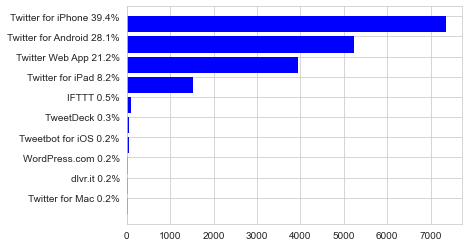

In [50]:
def get_source_name(x):
    value = re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)
    if len(value) > 0:
        return value[0]
    else:
        return ""
dataset.source_name = dataset.source.apply(get_source_name)

source_counts = dataset.source_name.value_counts().sort_values()[-10:]

bottom = [index for index, item in enumerate(source_counts.index)]
plt.barh(bottom, width=source_counts, color="blue", linewidth=0)

y_labels = ["%s %.1f%%" % (item, 100.0*source_counts[item]/len(dataset)) for index,item in enumerate(source_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)

source_counts

tr         9
zh         9
lt        10
de        10
in        16
ja        28
fr        51
es       100
und      609
en     17755
Name: lang, dtype: int64

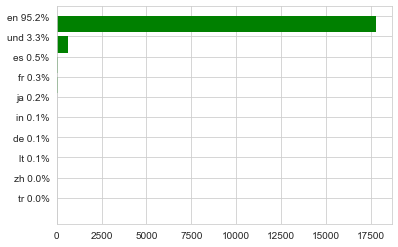

In [51]:
lang_counts = dataset.lang.value_counts().sort_values()[-10:]
bottom = [index for index, item in enumerate(lang_counts.index)]
plt.barh(bottom, width=lang_counts, color="green", linewidth=0)
y_labels = ["%s %.1f%%" % (item, 100.0*lang_counts[item]/len(dataset)) for index,item in enumerate(lang_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)
lang_counts

In [52]:
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from  textblob import TextBlob

In [53]:
dataset1 = [{"id": item["id"],
            "text": item["text"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset1 = pd.DataFrame(dataset1)

is_dataset1=dataset1.lang=="en"
dataset1=dataset1[is_dataset1]
dataset1

,id,text,lang
0,1320591611781263361,RT @donwinslow: Dear @NBCNews \n\nLet me rewri...,en
1,1320591612100001792,RT @donwinslow: Dear @NBCNews \n\nLet me rewri...,en
2,1320591616508334085,"RT @BillKristol: Olivia's hometown, El Paso, a...",en
3,1320591617024167936,RT @RonaldKlain: As @JoeBiden said in the firs...,en
4,1320591617561108481,RT @matthwatson: just sucked mike pence's (@VP...,en
...,...,...,...
18655,1320646751041118208,RT @CharlesHurt: This woman is such a toddler....,en
18656,1320646752848916481,RT @Cjamesb4u: BEST - VP EVER. Mike Pence..🇺🇸 ...,en
18657,1320646753927004161,"The sick old man &amp; his ""I don't care"" wife...",en
18658,1320646761774546944,RT @Amy_Siskind: In past 24 hours:\n* 5 Pence ...,en


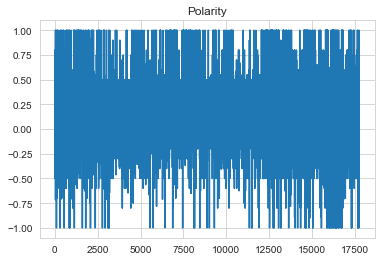

In [54]:
tweettext=dataset1['text']
wordlist=pd.DataFrame();

polarity=[]
subj=[]

for t in tweettext:
    tx= TextBlob(t)
    polarity.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)

poltweet= pd.DataFrame({'polarity':polarity,'subjectivity':subj})
poltweet.polarity.plot(title='Polarity')
plt.show()

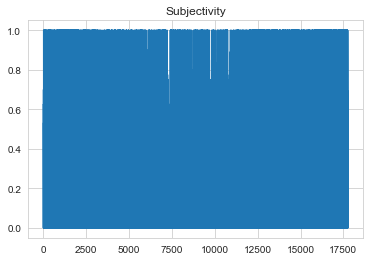

In [55]:
poltweet.subjectivity.plot(title='Subjectivity')
plt.show()

In [56]:
import statistics
statistics.mean(poltweet.polarity)

0.057270558472636235

In [57]:
import statistics
statistics.mean(poltweet.subjectivity)

0.34272484639957185

In [58]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [59]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
top_N = 100


a = dataset1['text'].str.lower().str.cat(sep=' ')


b = re.sub('[^A-Za-z]+', ' ', a)
nltk.download('stopwords')
nltk.download('punkt')
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)
word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


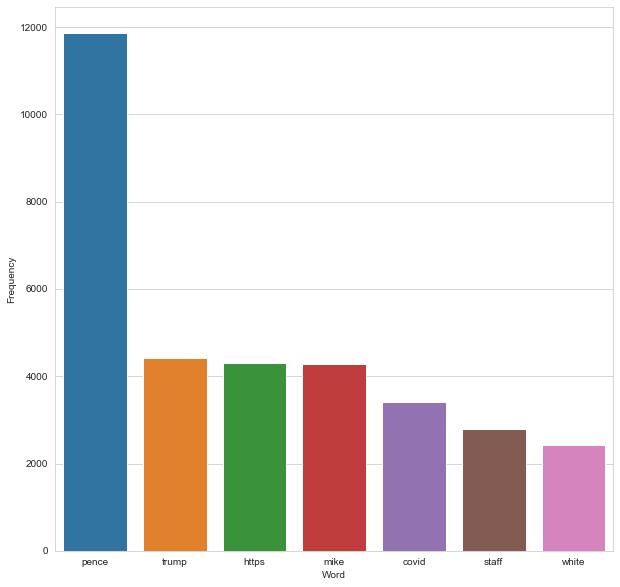

In [60]:
import seaborn as sns
 
without_single_chr = [word for word in filtered_sentence if len(word) > 2]


cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        


word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

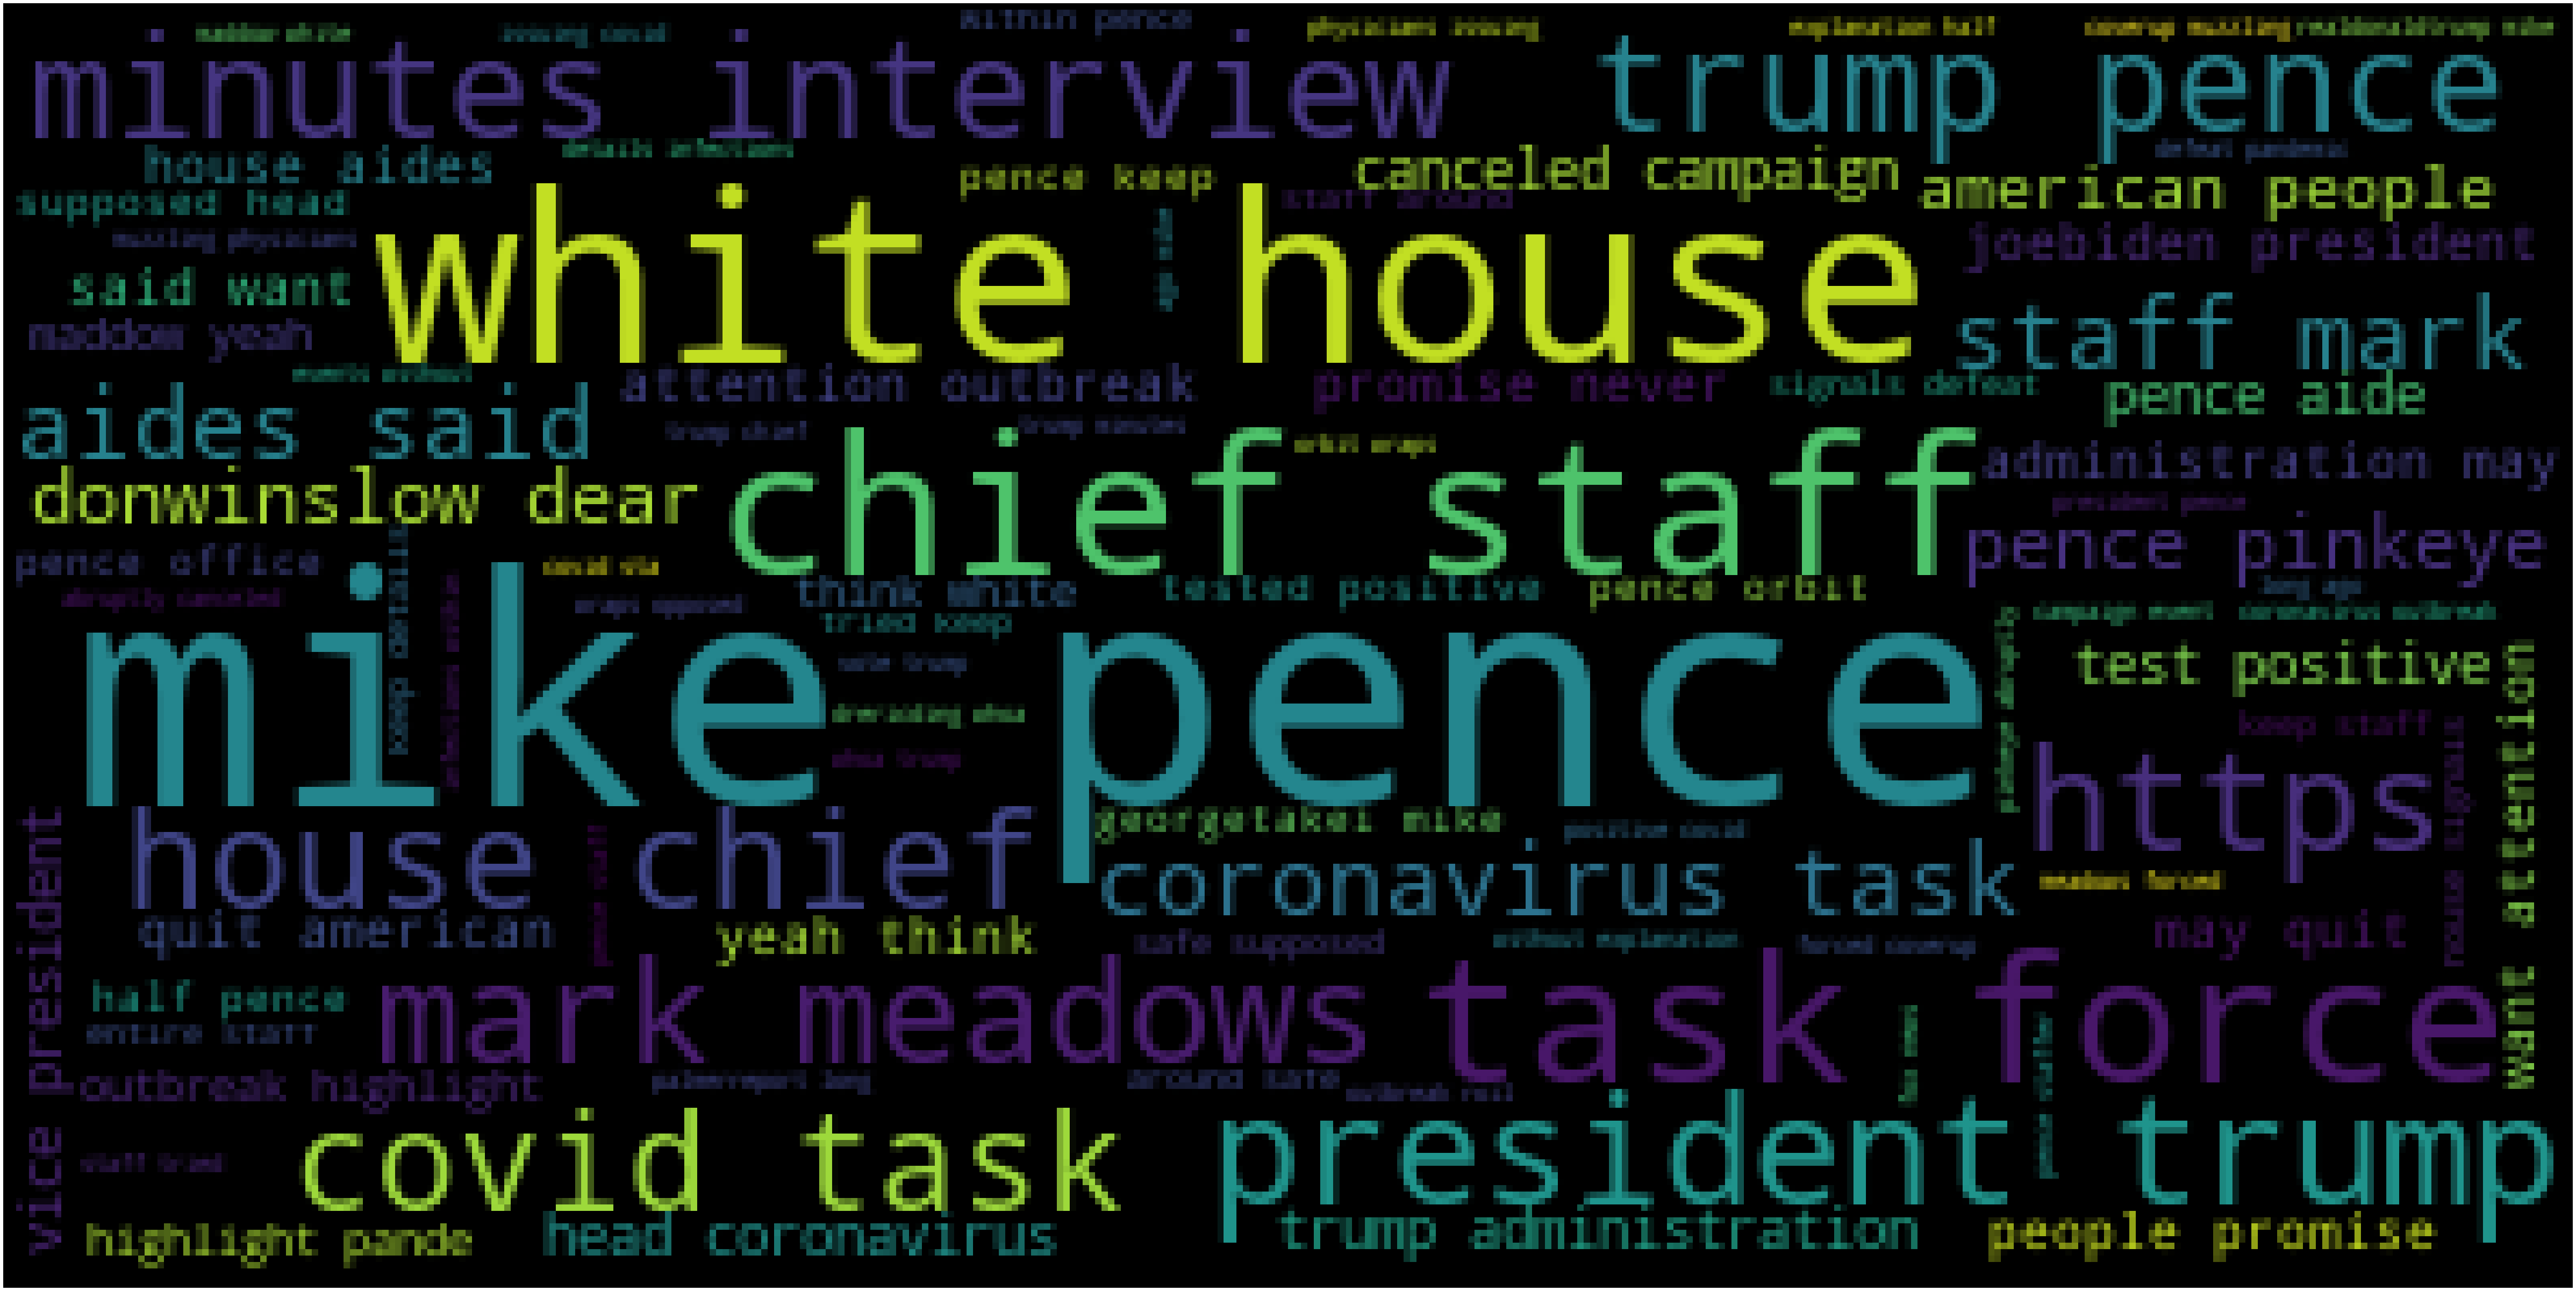

In [61]:
wc(cleaned_data_title,'black','Common Words' )

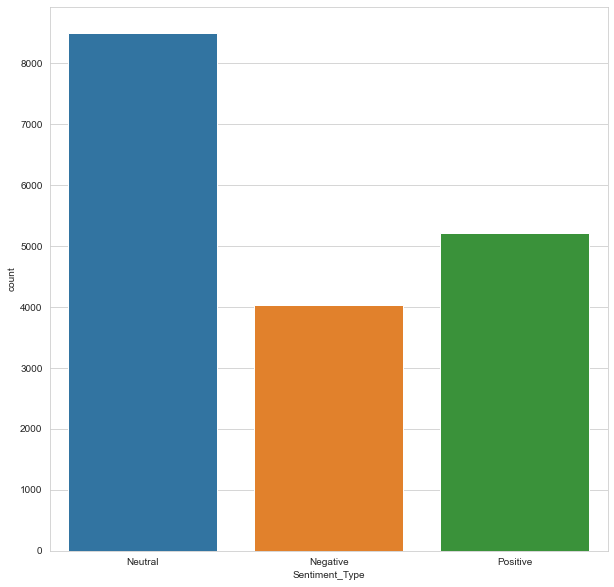

In [62]:
from textblob import TextBlob

bloblist_desc = list()

twit=dataset1['text'].astype(str)
for row in twit:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    twit_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])
    
def f(twit_polarity_desc):
    if twit_polarity_desc['sentiment'] > 0:
        val = "Positive"
    elif twit_polarity_desc['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

twit_polarity_desc['Sentiment_Type'] = twit_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=twit_polarity_desc)

In [63]:
import collections, numpy as np
a=twit_polarity_desc.Sentiment_Type
neut=np.count_nonzero(a == 'Neutral')
pos=np.count_nonzero(a == 'Positive')
neg=np.count_nonzero(a == 'Negative')
popularity='{0:.2f}'.format((((neut*0.5)+(pos)+(neg*0))/(neut+pos+neg))*100)
popularity

'53.31'